Deep Learning Project.
Group 10.
- Thomas Therkelsen (ththe20)
- Simon Vinkel (sivin11)
- Marc Egedal (maege17)

Finding relevant image infected with pnumonia. Firsly understanding the image.
- x-rays images are presented in greyscale.
- Pnumonia is presented by areas of opacity.
- Training images are classified binary as with or without pneumonia
- On all images, a reverse R is present on the left hand side.
- A trend is showing that a larger image size indicates "normal"

Below are the necessary imports for this program.

In [15]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import math
import shutil
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

from livelossplot import PlotLossesKeras
import sys
import os
from os import listdir

import pathlib

%matplotlib inline
mpl.rcParams['figure.dpi']= 200

print("GPU available? ", len(device_lib.list_local_devices())>0)

GPU available?  True


Data preprocessing

Research on this done by the whole group, implementation done by Thomas

In [2]:
# define directory paths
source_dir = "data/"
data_dir = "dataset/"
train_dir = data_dir+"train/"
test_dir = data_dir+"test/"
val_dir = data_dir+"validation/"

# if the folder does not already exist
if not os.path.exists(data_dir):
    # create it
    os.makedirs(data_dir)
    print(data_dir, " created")
    
if not os.path.exists(train_dir):
    # create it
    os.makedirs(train_dir)
    print(train_dir, " created")
if not os.path.exists(train_dir+"normal/"):
    os.makedirs(train_dir+"normal/")
    print(train_dir+"normal", " created")
if not os.path.exists(train_dir+"pneumonia/"):
    os.makedirs(train_dir+"pneumonia/")
    print(train_dir+"pneumonia/", " created")

if not os.path.exists(test_dir):
    os.makedirs(test_dir)
    print(test_dir, " created")
if not os.path.exists(test_dir+"normal/"):
    os.makedirs(test_dir+"normal/")
    print(test_dir+"normal/", " created")
if not os.path.exists(test_dir+"pneumonia/"):
    os.makedirs(test_dir+"pneumonia/")
    print(test_dir+"pneumonia/", " created")

if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    print(val_dir, " created")
if not os.path.exists(val_dir+"normal/"):
    os.makedirs(val_dir+"normal/")
    print(val_dir+"normal/", " created")
if not os.path.exists(val_dir+"pneumonia/"):
    os.makedirs(val_dir+"pneumonia/")
    print(val_dir+"pneumonia/", " created")

count = 0
# count images in data folder (should only be non-zero on first run of the code)
for path in os.listdir(source_dir):
    # check if current path is a file
    if os.path.isfile(os.path.join(source_dir, path)):
        # count it
        count += 1
        # if it isn't an image, delete it
        if(not path.endswith(".jpg")):
            print('deleting ', source_dir+path)
            os.remove(source_dir+path)
print('files in data folder (should only be nonzero on your first run of this code):', count)

num_files = count

train_percent = 80
val_percent = 10
test_percent = 10

num_train = int(math.floor(num_files * (train_percent / 100)))
num_val = int(math.floor(num_files * (val_percent / 100)))
num_test = int(math.floor(num_files * (test_percent / 100)))

# Using for loop to randomly choose multiple files
# moving test_percent % to the validation folder
for file in range(num_test):
    random_file=random.choice(os.listdir(source_dir))
    source_file="%s/%s"%(source_dir,random_file)
    if (random_file.endswith("a.jpg")):
        shutil.move(source_file,test_dir+"pneumonia/")
    else:
        shutil.move(source_file,test_dir+"normal/")

# moving val_percent % to the test folder
for file in range(num_val):
    random_file=random.choice(os.listdir(source_dir))
    source_file="%s/%s"%(source_dir,random_file)
    if (random_file.endswith("a.jpg")):
        shutil.move(source_file,val_dir+"pneumonia/")
    else:
        shutil.move(source_file,val_dir+"normal/")
        
# moving train_percent % files to the training folder
for file in os.listdir(source_dir):
    if (file.endswith("a.jpg")):
        shutil.move(source_dir+file,train_dir+"pneumonia/")
    else:
        shutil.move(source_dir+file,train_dir+"normal/")

files in data folder (should only be nonzero on your first run of this code): 0


In [3]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

image_size = (256, 256)
input_shape = (256, 256, 1)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=45,
    zoom_range=0.2,
    fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=image_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="binary",
    subset='training',
    shuffle=True,
    seed=int(time.time())
    #preprocessing_function=to_grayscale_then_rgb
)

val_generator = test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=image_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='binary'
    #preprocessing_function=to_grayscale_then_rgb
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=image_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='binary'
    #preprocessing_function=to_grayscale_then_rgb
)

Found 1760 images belonging to 2 classes.
Found 220 images belonging to 2 classes.
Found 220 images belonging to 2 classes.


In [29]:
num_epochs = 25
lr = 1e-3
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size

inputs = tf.keras.Input(input_shape)
x = Dropout(0.2)(inputs)
x = Conv2D(2 ** 4,
           kernel_size=(3, 3),
           activation='selu',
           input_shape=input_shape)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(2 ** 5,
           kernel_size=(3, 3),
           activation='selu',
           input_shape=input_shape)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(2 ** 6,
           kernel_size=(3, 3),
           activation='selu',
           input_shape=input_shape)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(2 ** 6,
           kernel_size=(3, 3),
           activation='selu',
           input_shape=input_shape)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(2**8, activation="selu")(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs, name="pneumonia_model")

print('layers added')
model.summary()
print("model parameters:")
print("batch size: ", batch_size)
print("epochs: ", num_epochs)
print("steps per epoch: ", steps_per_epoch)
print("validation steps: ", validation_steps)


# For a twin-class classification problem
model.compile(optimizer=optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['Accuracy'])
print('model compiled')

layers added
Model: "pneumonia_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 dropout_2 (Dropout)         (None, 256, 256, 1)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                 

In [30]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=[PlotLossesKeras()],
                    validation_data=val_generator,
                    validation_steps=validation_steps)

Epoch 1/25
13/55 [======>.......................] - ETA: 15s - loss: 3.3033 - Accuracy: 0.4856

KeyboardInterrupt: 

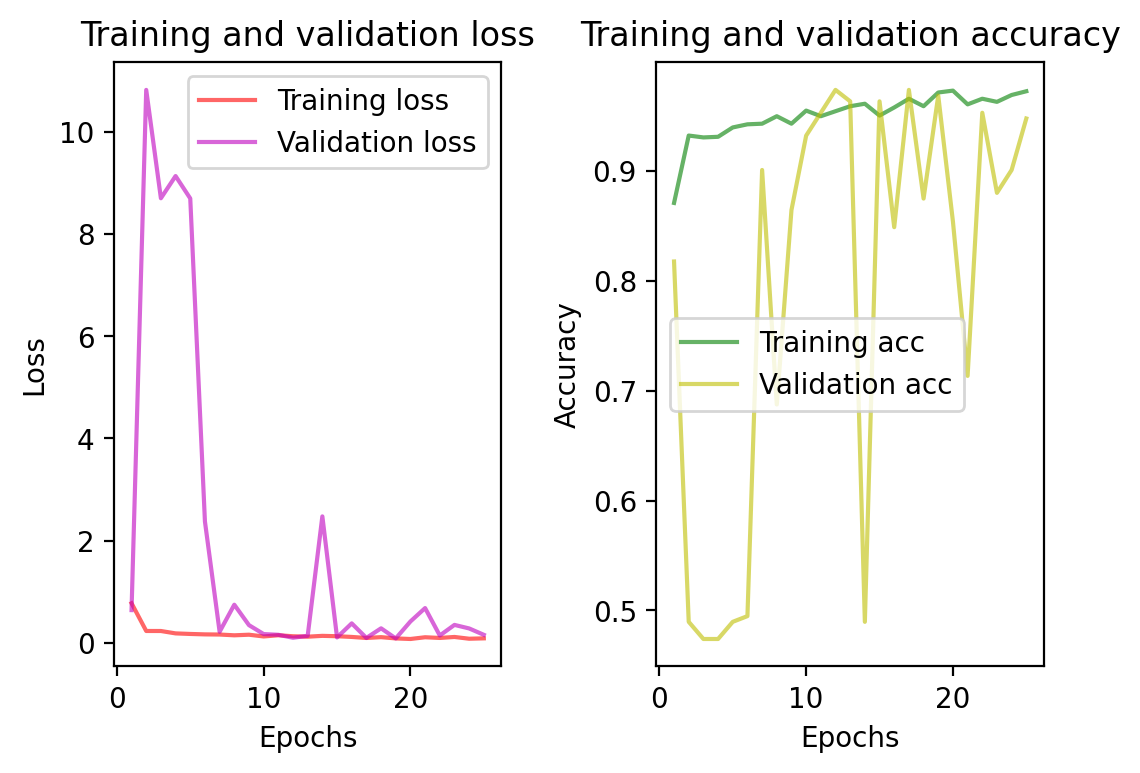

In [27]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['Accuracy']
val_acc_values = history_dict['val_Accuracy']
epochs = range(1, len(loss_values) + 1)
# 'bo' is for blue dot, 'b' is for solid blue line

plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4)
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'r-', label='Training loss', alpha=0.6)
plt.plot(epochs, val_loss_values, 'm-', label='Validation loss', alpha=0.6)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, 'g-', label='Training acc', alpha=0.6)
plt.plot(epochs, val_acc_values, 'y-', label='Validation acc', alpha=0.6)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()